In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  # Added missing import
import seaborn as sns
import glob
import os
import openpyxl
from IPython.display import display, HTML
from typing import Dict, Optional, List  # Added for type hints

from config import (
    BRAND_MAPPING,
    MODEL_MAPPING,
    PRODUCT_MAPPING,
    ANALYSIS_CONFIG,
    VIZ_CONFIG,
)

# Import project utilities
import sys

sys.path.append("../../../")
from src.utils.data_processing import *  # noqa: F403
from src.utils.visualization import *  # noqa: F403

# Visualization settings
plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline
sns.set_palette("viridis")
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option("display.max_columns", None)

# For reproducibility
np.random.seed(42)

# Configuration
XLSX_DATA_PATH = "../../../data/raw/aquaculture/aerator_imports/*.xlsx"
OUTPUT_DIR = "../../../data/processed/ecuasino/df1/"

# Global visualization settings
used_colors = set()
site_color_mapping = {}
available_css4_colors = list(mcolors.CSS4_COLORS.keys())


def load_excel_files(data_path: str) -> Optional[pd.DataFrame]:
    """
    Load Excel files and return only the first valid DataFrame (df1).

    Args:
        data_path (str): Path pattern for Excel files

    Returns:
        Optional[pd.DataFrame]: The first loaded DataFrame or None
    """
    try:
        files = glob.glob(data_path)
        if not files:
            print("No Excel files found matching the pattern.")
            return None

        for file in files:
            print(f"Loading data from {file}")

            # Load workbook with openpyxl for inspection
            wb = openpyxl.load_workbook(file, data_only=True, read_only=True)
            file_basename = os.path.basename(file)

            print(f"\nWorkbook: {file_basename}")
            print(
                f"Contains {len(wb.sheetnames)} sheets: {', '.join(wb.sheetnames)}"
            )

            # Process first valid sheet only
            for sheet_name in wb.sheetnames:
                df = _load_sheet_with_header_detection(
                    file, sheet_name, wb[sheet_name]
                )

                if df is not None and not df.empty:
                    print(f"  Loaded df1 with shape {df.shape}")
                    wb.close()
                    return df

            wb.close()

        print("No valid data found in any sheets.")
        return None

    except Exception as e:
        print(f"Error loading data: {e}")
        raise


def _load_sheet_with_header_detection(
    file_path: str, sheet_name: str, sheet
) -> pd.DataFrame:
    """
    Load a sheet with automatic header detection.

    Args:
        file_path (str): Path to the Excel file
        sheet_name (str): Name of the sheet
        sheet: Openpyxl sheet object

    Returns:
        pd.DataFrame: Loaded DataFrame or None if sheet is empty
    """
    try:
        # Check if sheet is empty
        if not sheet.max_row or not sheet.max_column:
            print(
                f"  Warning: Sheet '{sheet_name}' appears to be empty or corrupted"
            )
            return None

        print(f"\n  Sheet: '{sheet_name}'")
        print(
            f"  Dimensions: {sheet.max_row} rows x {sheet.max_column} columns"
        )

        # Check for merged cells
        try:
            merged_cells = list(sheet.merged_cells.ranges)
            if merged_cells:
                print(f"  Contains {len(merged_cells)} merged cell ranges")
        except AttributeError:
            print("  Note: Cannot check merged cells in read-only mode")

        # Load initial DataFrame without headers
        df = pd.read_excel(
            file_path,
            sheet_name=sheet_name,
            header=None,
            na_values=["NA", "N/A", ""],
            keep_default_na=True,
        )

        # Detect header row
        header_row = _detect_header_row(df)

        if header_row is not None:
            # Reload with detected header
            df = pd.read_excel(
                file_path,
                sheet_name=sheet_name,
                header=header_row,
                na_values=["NA", "N/A", ""],
                keep_default_na=True,
            )
            print(f"  Detected header at row {header_row + 1}")

        return df

    except Exception as e:
        print(f"  Error loading sheet '{sheet_name}': {e}")
        return None


def _detect_header_row(df: pd.DataFrame) -> int:
    """
    Detect the most likely header row in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame to analyze

    Returns:
        int: Index of the header row, or None if not found
    """
    for i in range(min(10, len(df))):
        str_count = sum(1 for x in df.iloc[i] if isinstance(x, str))
        if str_count > 0.5 * df.shape[1]:  # More than half are strings
            return i
    return None


# Step 1: Load data
print("\n" + "=" * 60)
print("STEP 1: LOADING DATA")
print("=" * 60)
df1 = load_excel_files(XLSX_DATA_PATH)

if df1 is None:
    print("❌ No data loaded. Please check the file path and try again.")
    sys.exit(1)


def clean_single_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply cleaning to a single DataFrame.

    Args:
        df (pd.DataFrame): DataFrame to clean

    Returns:
        pd.DataFrame: Cleaned DataFrame
    """
    print("Starting data cleaning process...")

    # Apply cleaning steps in order
    df = standardize_headers_single(df)
    df = remove_empty_rows_and_cols_single(df)
    df = handle_nan_values_single(df)
    df = title_case_columns_single(df)

    print("Data cleaning completed!")
    return df


def standardize_headers_single(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column headers for a single DataFrame."""
    print("STANDARDIZING DATAFRAME HEADERS")

    # Handle unnamed columns
    df = _fix_unnamed_columns(df)

    # Standardize date columns
    df = _standardize_date_columns(df)

    print("Header standardization complete!")
    return df


def remove_empty_rows_and_cols_single(df: pd.DataFrame) -> pd.DataFrame:
    """Remove completely empty rows and columns from DataFrame."""
    original_shape = df.shape
    df = df.dropna(how="all").dropna(axis=1, how="all")
    print(f"Cleaned df1: {original_shape} -> {df.shape}")
    return df


def handle_nan_values_single(df: pd.DataFrame) -> pd.DataFrame:
    """Analyze and selectively handle NaN values in DataFrame."""
    print(f"\n{'-' * 50}")
    print("NaN analysis for df1:")

    # Calculate NaN statistics
    total_cells = df.shape[0] * df.shape[1]
    nan_count = df.isna().sum().sum()
    nan_percentage = (nan_count / total_cells) if total_cells > 0 else 0

    print(
        f"- Total NaN values: {nan_count} ({nan_percentage:.1%} of all cells)"
    )

    # Handle high-NaN columns
    df = _remove_high_nan_columns(df)

    # Handle critical row removal
    df = _remove_critical_nan_rows(df)

    print(f"- Final shape after analysis: {df.shape}")
    return df


def title_case_columns_single(df: pd.DataFrame) -> pd.DataFrame:
    """Apply title case to column names."""
    df.columns = df.columns.str.title()
    return df


def _fix_unnamed_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Fix unnamed columns by replacing them with meaningful names."""
    columns = df.columns.tolist()
    for i, col in enumerate(columns):
        if str(col).startswith("Unnamed"):
            columns[i] = f"Column_{i}"
    df.columns = columns
    return df


def _standardize_date_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize date column names."""
    date_column_mapping = {
        "fecha_embarque": "Fecha De Embarque",
        "fecha_llegada": "Fecha De Llegada",
        "fecha_ingreso": "Fecha Ingreso Sistema",
        "fecha_pago": "Fecha Pago",
        "fecha_liquidacion": "Fecha De Liquidación",
        "fecha_aforo": "Fecha Aforo",
        "fecha_salida": "Fecha Salida",
    }

    # Apply mapping if columns exist
    df.columns = [
        date_column_mapping.get(col.lower().replace(" ", "_"), col)
        for col in df.columns
    ]
    return df


def _remove_high_nan_columns(
    df: pd.DataFrame, threshold: float = 0.8
) -> pd.DataFrame:
    """Remove columns with high percentage of NaN values."""
    nan_percentage = df.isnull().sum() / len(df)
    high_nan_cols = nan_percentage[nan_percentage > threshold].index.tolist()

    if high_nan_cols:
        print(
            f"- Removing {len(high_nan_cols)} columns with >{threshold * 100}% NaN values"
        )
        df = df.drop(columns=high_nan_cols)

    return df


def _remove_critical_nan_rows(df: pd.DataFrame) -> pd.DataFrame:
    """Remove rows where critical columns are all NaN."""
    critical_columns = [
        "Us$ Fob",
        "Cantidad",
        "Descripcion Producto Comercial",
    ]
    existing_critical = [col for col in critical_columns if col in df.columns]

    if existing_critical:
        before_count = len(df)
        df = df.dropna(subset=existing_critical, how="all")
        removed = before_count - len(df)
        if removed > 0:
            print(f"- Removed {removed} rows with all critical columns as NaN")

    return df


def _print_single_dataframe_info(name: str, df: pd.DataFrame) -> None:
    """Print comprehensive information about a DataFrame."""
    print(f"\n{'-' * 50}")
    print(f"DataFrame: {name}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Memory usage
    memory_mb = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Memory usage: {memory_mb:.2f} MB")

    # Data types summary
    dtype_counts = df.dtypes.value_counts()
    print(f"Data types: {dict(dtype_counts)}")

    # Missing values summary
    missing_summary = df.isnull().sum()
    missing_cols = missing_summary[missing_summary > 0]
    if len(missing_cols) > 0:
        print(f"Columns with missing values: {len(missing_cols)}")
        print(f"Total missing values: {missing_summary.sum()}")
    else:
        print("No missing values found")

    print(f"{'-' * 50}")


# Step 2: Clean data
print("\n" + "=" * 60)
print("STEP 2: CLEANING DATA")
print("=" * 60)
df1 = clean_single_dataframe(df1)


def analyze_single_dataframe(df: pd.DataFrame) -> None:
    """Print comprehensive analysis of the DataFrame."""
    print("Analyzing df1...\n")
    _print_single_dataframe_info("df1", df)


def preview_single_dataframe_html(df: pd.DataFrame) -> None:
    """Display DataFrame as scrollable HTML table."""
    print(f"{'=' * 50}")
    print("Previewing df1...")

    html_table = df.head(10).to_html(index=False, max_rows=10)
    styled_html = f"""
    <div style="overflow-x: auto; max-height: 500px; overflow-y: auto;">
        {html_table}
    </div>
    """
    display(HTML(styled_html))
    print(f"{'=' * 50}\n")


def display_single_datatypes(df: pd.DataFrame) -> None:
    """Display data types for the DataFrame in HTML table."""
    print(f"{'=' * 50}")
    print(f"DataFrame: df1 with shape {df.shape}")
    print(f"{'=' * 50}")

    dtype_df = pd.DataFrame(df.dtypes).reset_index()
    dtype_df.columns = ["Column", "Data Type"]
    display(HTML(dtype_df.to_html(index=False)))
    print(f"{'=' * 50}\n")


# Step 3: Analyze data
print("\n" + "=" * 60)
print("STEP 3: ANALYZING DATA")
print("=" * 60)
analyze_single_dataframe(df1)


def get_data_summary(df: pd.DataFrame) -> Dict[str, int]:
    """Get summary statistics for loaded data."""
    if df is None or df.empty:
        print("No dataframe loaded. Please load data first.")
        return {}

    return {
        "total_records": len(df),
        "total_columns": len(df.columns),
        "memory_usage_mb": round(
            df.memory_usage(deep=True).sum() / 1024**2, 2
        ),
        "missing_values": df.isna().sum().sum(),
    }


# Step 4: Display data summary
print("\n" + "=" * 60)
print("STEP 4: DISPLAYING DATA SUMMARY")
print("=" * 60)
data_summary = get_data_summary(df1)
print("Data Summary:")
for key, value in data_summary.items():
    print(f"  {key.replace('_', ' ').title()}: {value}")

# Step 5: Preview DataFrame
print("\n" + "=" * 60)
print("STEP 5: PREVIEWING DATAFRAME")
print("=" * 60)
preview_single_dataframe_html(df1)

# Step 6: Display Data Types
print("\n" + "=" * 60)
print("STEP 6: DISPLAYING DATA TYPES")
print("=" * 60)
display_single_datatypes(df1)


def convert_date_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Convert date columns to datetime format."""
    df_cleaned = df.copy()
    conversion_results = []

    # Use actual Spanish column names from the data
    actual_date_columns = [
        "Fecha De Embarque",
        "Fecha De Llegada",
        "Fecha Ingreso Sistema",
        "Fecha Pago",
        "Fecha De Liquidación",
        "Fecha Aforo",
        "Fecha Salida",
    ]

    for col in actual_date_columns:
        if col in df_cleaned.columns:
            orig_nulls = df_cleaned[col].isnull().sum()
            # Parse dates with dd/mm/yyyy format
            df_cleaned[col] = pd.to_datetime(
                df_cleaned[col], format="%d/%m/%Y", errors="coerce"
            )
            new_nulls = df_cleaned[col].isnull().sum()

            conversion_results.append(
                {
                    "column": col,
                    "orig_nulls": orig_nulls,
                    "new_nulls": new_nulls,
                    "conversion_errors": new_nulls - orig_nulls,
                }
            )

    print(
        f"🗓️  Converted {len([c for c in actual_date_columns if c in df.columns])} date columns"
    )
    return df_cleaned


def standardize_categorical_data(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize brand, model, and product data."""
    df_cleaned = df.copy()

    # Use actual Spanish column names from the data
    categorical_columns = {
        "Marca": BRAND_MAPPING,
        "Modelo Mercaderia": MODEL_MAPPING,
        "Descripcion Producto Comercial": PRODUCT_MAPPING,
        "Marca Comercial": BRAND_MAPPING,
    }

    cleaned_cols = 0
    for col, mapping in categorical_columns.items():
        if col in df_cleaned.columns:
            # Fill NaN values
            df_cleaned[col] = df_cleaned[col].fillna("GENERICO")
            # Apply mapping
            df_cleaned[col] = df_cleaned[col].replace(mapping)
            # Standardize case
            df_cleaned[col] = df_cleaned[col].astype(str).str.upper()
            cleaned_cols += 1

    print(f"🏷️  Standardized {cleaned_cols} categorical columns")
    return df_cleaned


def clean_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and convert numeric columns, handling concatenated or invalid data."""
    df_cleaned = df.copy()

    # Use actual column names from the data
    numeric_columns = [
        "Us$ Fob Unit",
        "Cantidad",
        "Us$ Fob",
        "Peso Neto Kg",
        "Us$ Cif",
        "Us$ Flete",
        "Us$ Seguro",
        "Advalorem",
    ]

    cleaned_cols = 0
    for col in numeric_columns:
        if col in df_cleaned.columns:
            # Convert to string first to handle any data type issues
            df_cleaned[col] = df_cleaned[col].astype(str)

            def clean_numeric_value(value):
                if pd.isna(value) or value in ["nan", "NaN", ""]:
                    return np.nan

                value_str = str(value).strip()

                # If it's too long, it's likely concatenated data
                if len(value_str) > 20:
                    return np.nan

                # Remove non-numeric characters but keep decimal separators
                import re

                cleaned = re.sub(r"[^\d.,\-]", "", value_str)

                if not cleaned:
                    return np.nan

                try:
                    # Handle comma as decimal separator
                    if "," in cleaned and "." not in cleaned:
                        cleaned = cleaned.replace(",", ".")
                    elif "," in cleaned and "." in cleaned:
                        cleaned = cleaned.replace(",", "")

                    return float(cleaned)
                except (ValueError, TypeError):
                    return np.nan

            # Apply cleaning
            df_cleaned[col] = df_cleaned[col].apply(clean_numeric_value)
            # Convert to numeric
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors="coerce")
            cleaned_cols += 1

    print(f"💰 Cleaned {cleaned_cols} numeric columns")
    return df_cleaned


def clean_full_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    """Apply the complete cleaning pipeline."""
    print("🧹 Starting data cleaning pipeline...")

    # Convert dates
    df_cleaned = convert_date_columns(df)

    # Standardize categorical data
    df_cleaned = standardize_categorical_data(df_cleaned)

    # Clean numeric columns
    df_cleaned = clean_numeric_columns(df_cleaned)

    print("✅ Data cleaning pipeline completed")
    return df_cleaned


# Call the full cleaning pipeline on df1
df_cleaned = clean_full_pipeline(df1)
print(f"\n✅ Final cleaned dataframe shape: {df_cleaned.shape}")



STEP 1: LOADING DATA
Loading data from ../../../data/raw/aquaculture/aerator_imports/Importaciones de Ecuasino.xlsx

Workbook: Importaciones de Ecuasino.xlsx
Contains 2 sheets: Datasur, Filtros

  Sheet: 'Datasur'
  Dimensions: 270 rows x 59 columns
  Note: Cannot check merged cells in read-only mode
  Detected header at row 1
  Loaded df1 with shape (269, 59)

STEP 2: CLEANING DATA
Starting data cleaning process...
STANDARDIZING DATAFRAME HEADERS
Header standardization complete!
Cleaned df1: (269, 59) -> (269, 57)

--------------------------------------------------
NaN analysis for df1:
- Total NaN values: 1018 (6.6% of all cells)
- Removing 1 columns with >80.0% NaN values
- Final shape after analysis: (269, 56)
Data cleaning completed!

STEP 3: ANALYZING DATA
Analyzing df1...


--------------------------------------------------
DataFrame: df1
Shape: (269, 56)
Columns: ['Dia', 'Mes', 'Año', 'Regimen Aduanero', 'Refrendo', 'Dau', 'Item', 'Ruc Importador', 'Probable Importador', 'País

Dia,Mes,Año,Regimen Aduanero,Refrendo,Dau,Item,Ruc Importador,Probable Importador,País De Origen,País De Procedencia,Ciudad Embarque,Vía De Transporte,Aduana,Partida Arancelaria,Descripción Arancelaria,Descripcion Producto Comercial,Marca,Estado De Mercancia,Bultos,Cantidad,Unidad De Medida,Advalorem,Us$ Fob,Us$ Flete,Us$ Seguro,Us$ Cif,Embarcador,Empresa De Transporte,País De Embarque,Contenedor,Agente De Aduana,Nave,Número De Manifiesto,Conocimiento Embarque,Deposito Comercial,Peso Neto Kg,Tipo Aforo,Fecha De Embarque,Fecha De Llegada,Fecha Ingreso Sistema,Fecha Pago,Factura,Características,Producto,Marca Comercial,Año Fabricación,Modelo Mercaderia,Us$ Fob Unit,Fecha De Liquidación,Fecha Aforo,Incoterm,Agencia De Carga,Código Tnan,Numero De Carga Final,Fecha Salida
28,1,2025,IMPORTACION COURIER,019-2025-91-00231603,NaN,1,992717769001,IMPORTADORA ECUASINO S.A.,CHINA,CHINA,MIAMI,AEREA,GUAYAQUIL AEREO,8479900000,Partes,RECTIFICADOR,NaN,NUEVA,1,160,NUMERO DE UNIDADES,0.00,577.6,16.56,5.78,599.94,"LINGWODA LOT TECHNOLOGY CO.,LTD-UNITED PARCEL SERVICE CO",AVIANCA - ECUADOR S.A.,UNITED STATES,0,08901058-UPS SCS (ECUADOR) S.A.S.,N818AV,CEC20252K300098,1ZC222K50400841367,-,12.00,AFORO-AFORO AUTOMATICO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.00,NaN,NaN,NaN,UPS SCS (ECUADOR) CIA. LTDA.,0,CEC20252K30009800010129,NaN
28,1,2025,IMPORTACION COURIER,019-2025-91-00231603,NaN,2,992717769001,IMPORTADORA ECUASINO S.A.,CHINA,CHINA,MIAMI,AEREA,GUAYAQUIL AEREO,7415290000,Los demás,CUBIERTA,NaN,NUEVA,1,600,NUMERO DE UNIDADES,11.94,62.4,16.56,0.62,79.58,"LINGWODA LOT TECHNOLOGY CO.,LTD-UNITED PARCEL SERVICE CO",AVIANCA - ECUADOR S.A.,UNITED STATES,0,08901058-UPS SCS (ECUADOR) S.A.S.,N818AV,CEC20252K300098,1ZC222K50400841367,-,12.00,AFORO-AFORO AUTOMATICO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.00,NaN,NaN,NaN,UPS SCS (ECUADOR) CIA. LTDA.,0,CEC20252K30009800010129,NaN
9,1,2025,IMPORTACION A CONSUMO,028-2025-10-00056665,12.0,17,992717769001,IMPORTADORA ECUASINO S.A.,CHINA,CHINA,SHANGHAI,MARITIMO,GUAYAQUIL MARITIMO,8484100000,JUNTAS METALOPLASTICAS,EMPAQUE CABEZOTE 1100,S/MARCA,NUEVA,1683,2000,NUMERO DE UNIDADES,0.00,860.0,22.13,0.97,883.10,"BAODING XUANJINGCHUANGHONG IMPORT AND EXPORT TRADING CO.,LTD",BROOM-ECUADOR S.A.,CHINA,1,01777905-GUERRERO VELASQUEZ ALEJANDRO JAVIER,KOTA PEONY,CEC2025PCIU0001,SHSE41906800,05909025-CONTECON GUAYAQUIL S.A.,221.13,AFORO-AFORO AUTOMATICO,NaN,NaN,NaN,NaN,XJCH-SINO-049,REPUESTOS,EMPAQUE CABEZOTE 1100,S/MARCA,2025,S/MODELO,0.43,NaN,NaN,FOB,ZZ OTROS LIBERADORES DIRECTOS,0,CEC2025PCIU00010248,NaN
9,1,2025,IMPORTACION A CONSUMO,028-2025-10-00056665,12.0,18,992717769001,IMPORTADORA ECUASINO S.A.,CHINA,CHINA,SHANGHAI,MARITIMO,GUAYAQUIL MARITIMO,8484100000,JUNTAS METALOPLASTICAS,CABEZOTE 195,S/MARCA,NUEVA,1683,100,NUMERO DE UNIDADES,0.00,1579.0,40.63,1.78,1621.41,"BAODING XUANJINGCHUANGHONG IMPORT AND EXPORT TRADING CO.,LTD",BROOM-ECUADOR S.A.,CHINA,1,01777905-GUERRERO VELASQUEZ ALEJANDRO JAVIER,KOTA PEONY,CEC2025PCIU0001,SHSE41906800,05909025-CONTECON GUAYAQUIL S.A.,406.01,AFORO-AFORO AUTOMATICO,NaN,NaN,NaN,NaN,XJCH-SINO-049,REPUESTOS,CABEZOTE 195,S/MARCA,2025,S/MODELO,15.79,NaN,NaN,FOB,ZZ OTROS LIBERADORES DIRECTOS,0,CEC2025PCIU00010248,NaN
9,1,2025,IMPORTACION A CONSUMO,028-2025-10-00056665,12.0,19,992717769001,IMPORTADORA ECUASINO S.A.,CHINA,CHINA,SHANGHAI,MARITIMO,GUAYAQUIL MARITIMO,8413309100,De carburante,BOMBA DE INYECCION / COMBUSTIBLE 195/1100,S/MARCA,NUEVA,1683,3130,NUMERO DE UNIDADES,0.00,22567.3,580.71,25.46,23173.48,"BAODING XUANJINGCHUANGHONG IMPORT AND EXPORT TRADING CO.,LTD",BROOM-ECUADOR S.A.,CHINA,1,01777905-GUERRERO VELASQUEZ ALEJANDRO JAVIER,KOTA PEONY,CEC2025PCIU0001,SHSE41906800,05909025-CONTECON GUAYAQUIL S.A.,5802.74,AFORO-AFORO AUTOMATICO,NaN,NaN,NaN,NaN,XJCH-SINO-049,REPUESTOS,BOMBA DE INYECCION / COMBUSTIBLE 195/1100,S/MARCA,2025,S/MODELO,7.21,NaN,NaN,FOB,ZZ OTROS LIBERADORES DIRECTOS,0,CEC2025PCIU00010248,NaN
9,1,2025,IMPORTACION A CONSUMO,028-2025-10-00056665,12.0,20,992717769001,IMPORTADORA ECUA



STEP 6: DISPLAYING DATA TYPES
DataFrame: df1 with shape (269, 56)


Column,Data Type
Dia,int64
Mes,int64
Año,int64
Regimen Aduanero,object
Refrendo,object
Dau,float64
Item,int64
Ruc Importador,int64
Probable Importador,object
País De Origen,object



🧹 Starting data cleaning pipeline...
🗓️  Converted 7 date columns
🏷️  Standardized 4 categorical columns
💰 Cleaned 8 numeric columns
✅ Data cleaning pipeline completed

✅ Final cleaned dataframe shape: (269, 56)


In [2]:
def get_missing_values_report(df: pd.DataFrame) -> pd.DataFrame:
    """Generate a comprehensive missing values report."""
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0].sort_values(
        ascending=False
    )

    missing_percent = (missing_values / len(df) * 100).round(2)

    report = pd.DataFrame(
        {
            "Missing Values": missing_values,
            "Percentage (%)": missing_percent,
        }
    )

    return report


def get_summary_statistics(df: pd.DataFrame) -> Dict[str, float]:
    """Calculate summary statistics for the dataset."""
    numeric_df = df.select_dtypes(include=[np.number])

    stats = {
        "total_rows": len(df),
        "total_columns": len(df.columns),
        "missing_cells": df.isnull().sum().sum(),
        "missing_percentage": (df.isnull().sum().sum() / df.size) * 100,
        "memory_usage_mb": df.memory_usage(deep=True).sum() / (1024**2),
        "numeric_columns": len(numeric_df.columns),
        "categorical_columns": len(df.columns) - len(numeric_df.columns),
    }

    return stats


def get_top_categories(
    df: pd.DataFrame, column: str, n: int = None
) -> pd.DataFrame:
    """Get top N categories for a given column."""
    if n is None:
        n = 10

    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in dataframe")

    top_categories = df[column].value_counts().head(n)

    result = pd.DataFrame(
        {
            column.title(): top_categories.index,
            "Count": top_categories.values,
            "Percentage (%)": (top_categories.values / len(df) * 100).round(2),
        }
    )

    return result


def analyze_price_distribution(
    df: pd.DataFrame, price_col: str = "Us$ Fob Unit"
) -> Dict[str, float]:
    """Analyze price distribution statistics."""
    if price_col not in df.columns:
        raise ValueError(f"Price column '{price_col}' not found")

    prices = df[price_col].dropna()

    stats = {
        "count": len(prices),
        "mean": prices.mean(),
        "median": prices.median(),
        "std": prices.std(),
        "min": prices.min(),
        "max": prices.max(),
        "q25": prices.quantile(0.25),
        "q75": prices.quantile(0.75),
        "q95": prices.quantile(0.95),
    }

    return stats


# Call the analysis functions
missing_report = get_missing_values_report(df_cleaned)
summary_stats = get_summary_statistics(df_cleaned)
top_brands = get_top_categories(df_cleaned, "Marca", n=10)
top_models = get_top_categories(df_cleaned, "Modelo Mercaderia", n=10)
top_products = get_top_categories(
    df_cleaned, "Descripcion Producto Comercial", n=10
)
# Analyze price distribution
price_stats = analyze_price_distribution(df_cleaned)
# Display the analysis results
print("\n" + "=" * 60)
print("ANALYSIS RESULTS")
print("=" * 60)
print("Missing Values Report:")
display(HTML(missing_report.to_html(index=True)))
print("\nSummary Statistics:")
print(summary_stats)
print("\nTop Brands:")
display(HTML(top_brands.to_html(index=False)))
print("\nTop Models:")
display(HTML(top_models.to_html(index=False)))
print("\nTop Products:")
display(HTML(top_products.to_html(index=False)))
print("\nPrice Distribution Statistics:")
print(price_stats)



ANALYSIS RESULTS
Missing Values Report:


,Missing Values,Percentage (%)
Fecha Pago,269,100.00
Fecha De Embarque,269,100.00
Fecha De Liquidación,269,100.00
Fecha Salida,269,100.00
Fecha Ingreso Sistema,269,100.00
Fecha De Llegada,269,100.00
Fecha Aforo,269,100.00
Incoterm,56,20.82
Agencia De Carga,50,18.59
País De Embarque,49,18.22



Summary Statistics:
{'total_rows': 269, 'total_columns': 56, 'missing_cells': np.int64(2106), 'missing_percentage': np.float64(13.980350504514071), 'memory_usage_mb': np.float64(0.5579109191894531), 'numeric_columns': 19, 'categorical_columns': 37}

Top Brands:


Marca,Count,Percentage (%)
GENERICO,253,94.05
ECUASINO,16,5.95



Top Models:


Modelo Mercaderia,Count,Percentage (%)
GENERICO,252,93.68
ZS1100NM,11,4.09
CF1100N,4,1.49
SR292FE,1,0.37
CF1115NM,1,0.37



Top Products:


Descripcion Producto Comercial,Count,Percentage (%)
AIREADOR DE RUEDA DE PALETA,18,6.69
DIESEL ENGINE,12,4.46
CIGUENAL 1105,8,2.97
BASE DE RADIADOR,7,2.60
CIGUENAL 195,6,2.23
CAMISA LISA 195,6,2.23
PISTON 195,5,1.86
CAMISA LISA 1100,5,1.86
PINON CIGUENAL,5,1.86
CAMISA CAMPANA 195,5,1.86



Price Distribution Statistics:
{'count': 269, 'mean': np.float64(108.41810408921934), 'median': np.float64(6.98), 'std': np.float64(210.21415230746794), 'min': np.float64(0.0), 'max': np.float64(677.0), 'q25': np.float64(1.5), 'q75': np.float64(53.12), 'q95': np.float64(675.0)}


🔍 Filtered data for aerator analysis:
Original dataset: 269 records
Aerator dataset: 30 records
Product types: {'AIREADOR DE RUEDA DE PALETA': 18, 'DIESEL ENGINE': 12}

AERATOR COMPARISON ANALYSIS
📊 Aerator Type Statistics:



🎨 Creating aerator comparison plots...


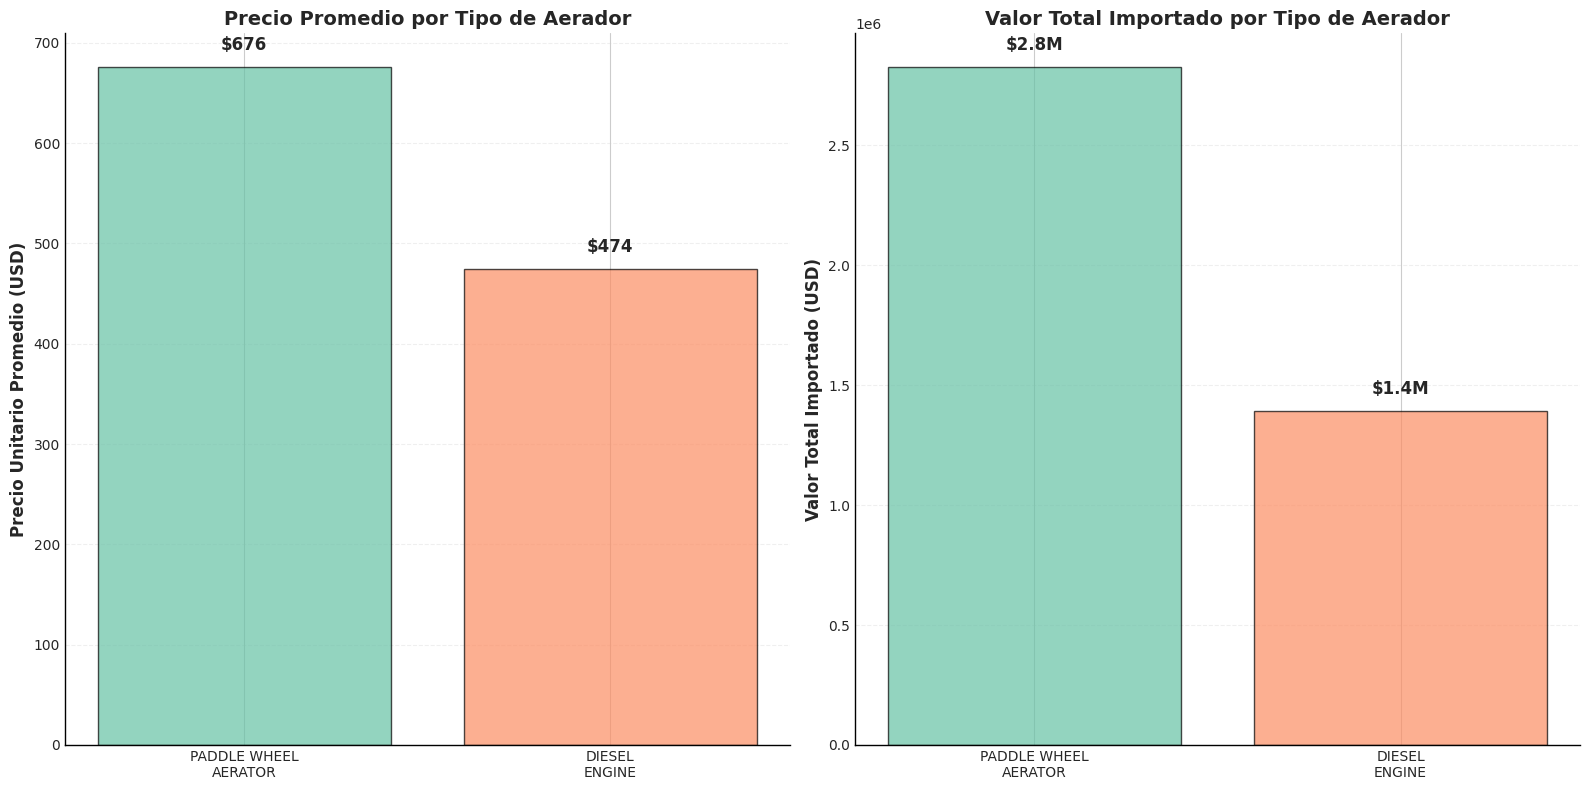

📊 Price distribution analysis:
Total prices: 269
Prices >= $400: 44 (16.4%)


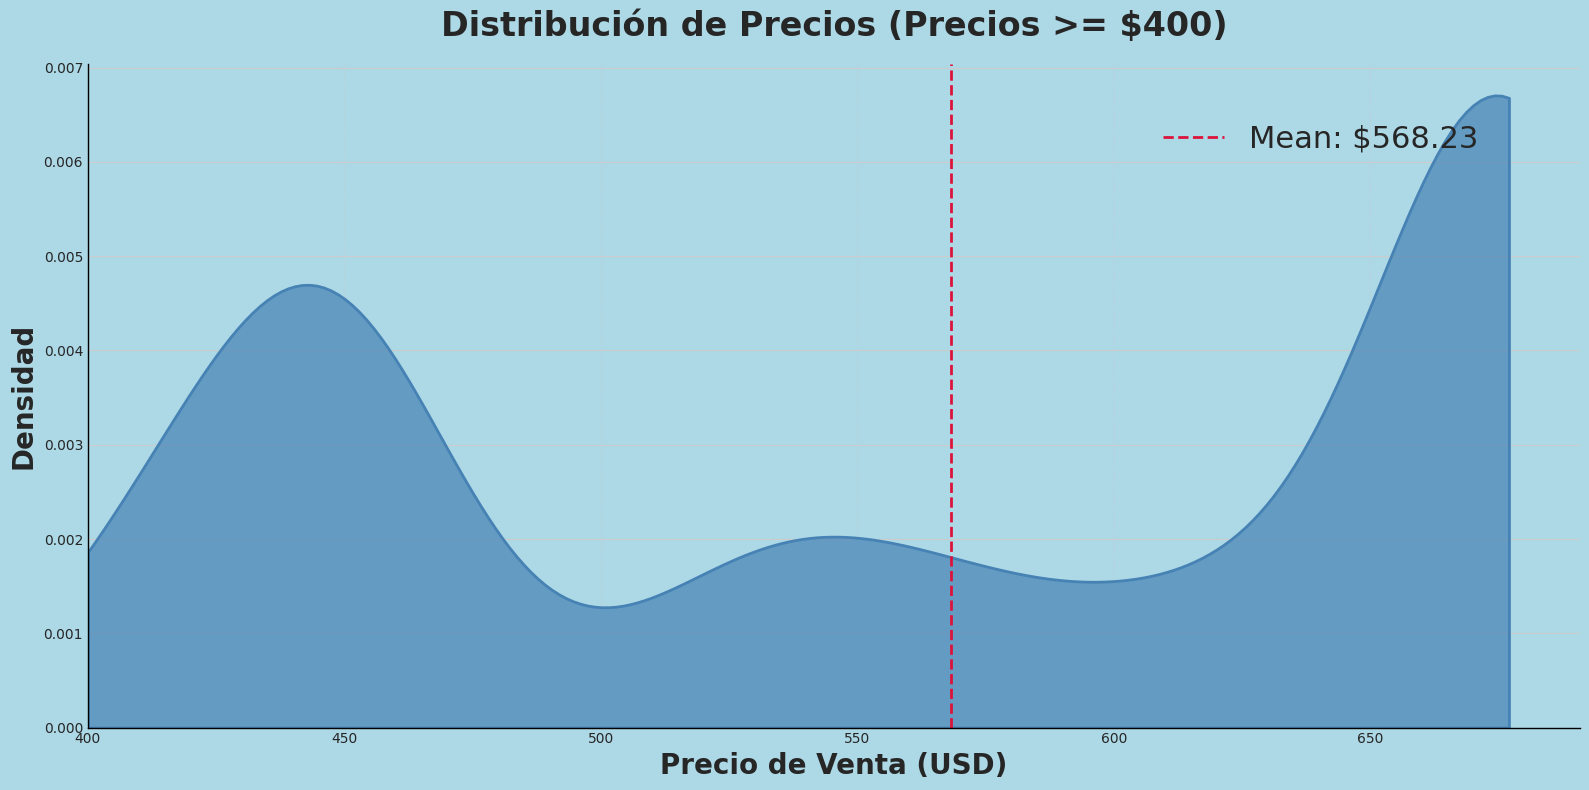

🎨 Creating categorical analysis plots...


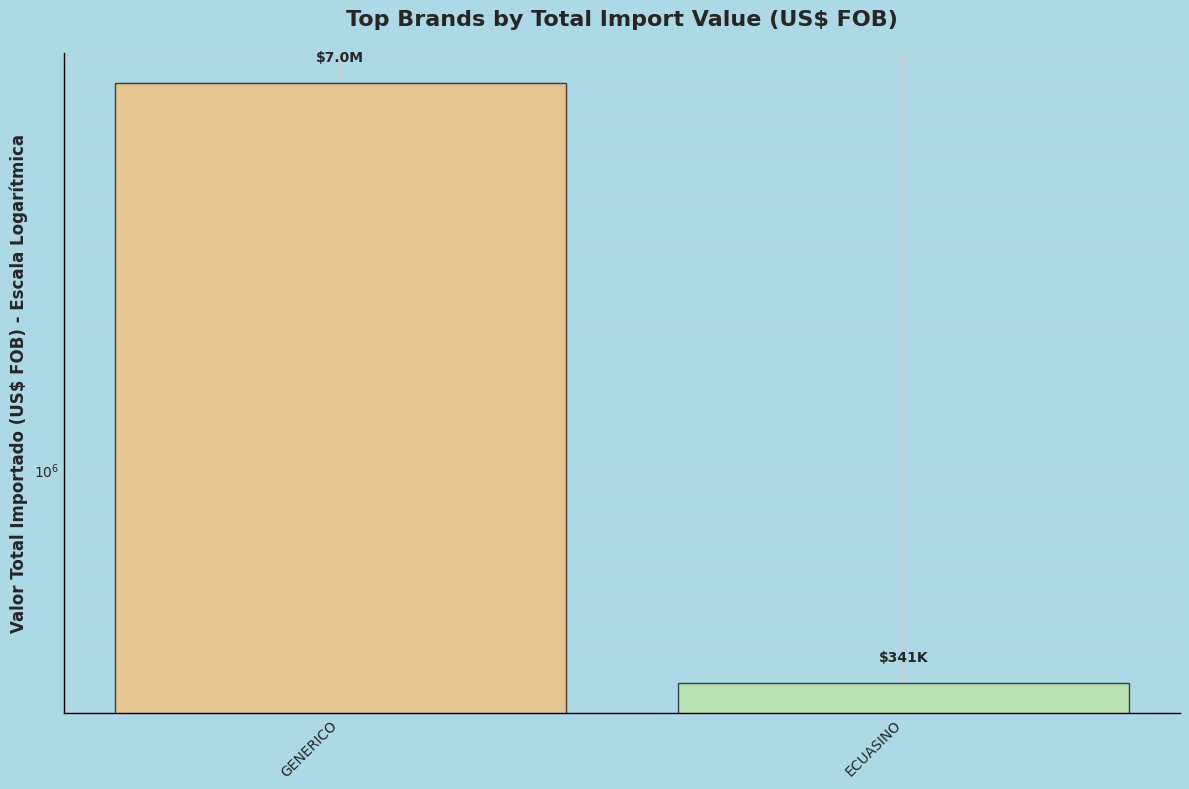

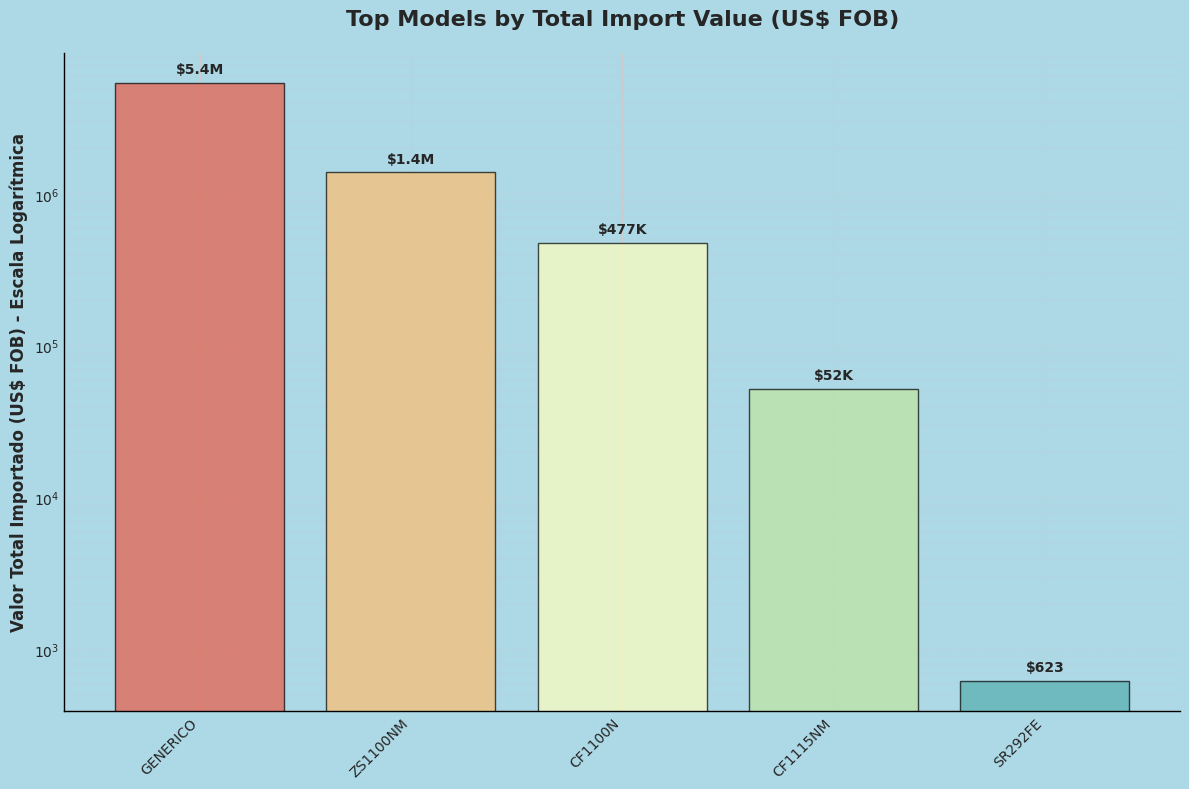

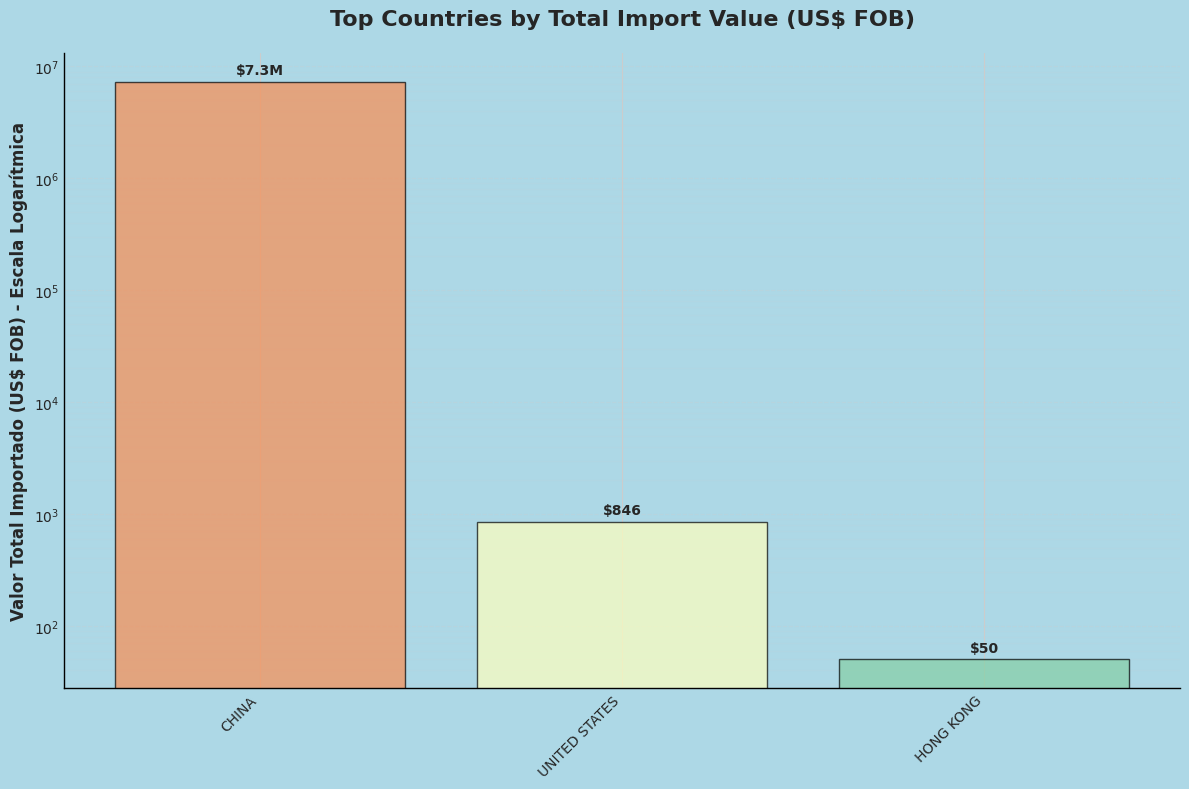

✅ Created 3 categorical analysis plots


In [7]:
sns.set_style(VIZ_CONFIG["style"])
plt.rcParams["figure.dpi"] = VIZ_CONFIG["dpi"]


def _setup_plot_style(fig: plt.Figure, ax: plt.Axes) -> None:
    """Apply consistent styling to plots."""
    fig.patch.set_facecolor(VIZ_CONFIG["background_color"])
    ax.set_facecolor(VIZ_CONFIG["background_color"])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("black")
    ax.spines["bottom"].set_color("black")


def _format_value(value: float) -> str:
    """Format large numbers with appropriate suffixes."""
    if value > 1000000:
        return f"{value / 1000000:.1f}M"
    elif value > 1000:
        return f"{value / 1000:.0f}K"
    else:
        return f"{value:,.0f}"


def create_price_distribution_plot(
    df: pd.DataFrame, price_col: str = "Us$ Fob Unit", min_price: float = 400
) -> plt.Figure:
    """Create price distribution analysis plot."""
    prices = df[price_col].dropna()

    # Filter prices to focus on $400 and above
    filtered_prices = prices[prices >= min_price]

    if len(filtered_prices) == 0:
        print(f"Warning: No prices found >= ${min_price}")
        return None

    print("📊 Price distribution analysis:")
    print(f"Total prices: {len(prices)}")
    print(
        f"Prices >= ${min_price}: {len(filtered_prices)} ({len(filtered_prices) / len(prices) * 100:.1f}%)"
    )

    # Calculate statistics
    mean_price = filtered_prices.mean()
    percentile_95 = filtered_prices.quantile(0.95)

    # Create figure for price distribution
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # Price distribution plot
    sns.kdeplot(
        data=filtered_prices,
        fill=True,
        color="steelblue",
        alpha=0.7,
        linewidth=2,
        clip=(min_price, percentile_95),
        bw_adjust=0.5,
        ax=ax,
    )

    # Add mean line
    ax.axvline(
        mean_price,
        color="crimson",
        linestyle="--",
        linewidth=2,
        label=f"Mean: ${mean_price:.2f}",
    )

    _setup_plot_style(fig, ax)

    ax.set_xlabel("Precio de Venta (USD)", fontsize=20, fontweight="bold")
    ax.set_ylabel("Densidad", fontsize=20, fontweight="bold")
    ax.set_title(
        f"Distribución de Precios (Precios >= ${min_price})",
        fontsize=24,
        fontweight="bold",
        pad=20,
    )
    ax.legend(loc="upper right", bbox_to_anchor=(0.95, 0.95), fontsize=22)
    ax.grid(axis="x", alpha=0.3, linestyle="--")

    # Set x-axis to start from the minimum price
    ax.set_xlim(left=min_price)

    plt.tight_layout()
    plt.show()
    return fig


def create_brand_price_comparison_plot(
    df: pd.DataFrame, price_col: str = "Us$ Fob Unit"
) -> plt.Figure:
    """Create brand price comparison plot."""
    # Check if required columns exist
    if price_col not in df.columns:
        print(f"Warning: Column '{price_col}' not found in DataFrame")
        return None

    if "Marca" not in df.columns:
        print("Warning: Column 'Marca' not found in DataFrame")
        return None

    # Calculate brand average prices
    brand_avg_prices = df.groupby("Marca")[price_col].mean().dropna()

    if len(brand_avg_prices) == 0:
        print("Warning: No valid brand price data found")
        return None

    # Filter brands for price analysis - make this more flexible
    price_range = ANALYSIS_CONFIG.get("price_filter_range", [0, float("inf")])
    filtered_brands = brand_avg_prices[
        (brand_avg_prices >= price_range[0])
        & (brand_avg_prices <= price_range[1])
    ]

    # If no brands pass the filter, use all brands
    if len(filtered_brands) == 0:
        print(
            f"No brands found in price range {price_range}, using all brands"
        )
        filtered_brands = brand_avg_prices

    # Take top 10 brands by price
    filtered_brands = filtered_brands.nlargest(10)

    if len(filtered_brands) == 0:
        print("Warning: No brands to display")
        return None

    # Create figure for brand comparison
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))

    # Create vertical bar plot
    colors = sns.color_palette(
        VIZ_CONFIG["color_palette"], len(filtered_brands)
    )

    bars = ax.bar(
        x=range(len(filtered_brands)),
        height=filtered_brands.values,
        color=colors,
        alpha=0.7,
        edgecolor="black",
        linewidth=1,
    )

    # Add value labels on top of bars
    max_value = max(filtered_brands.values)
    for i, (bar, value) in enumerate(zip(bars, filtered_brands.values)):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value + max_value * 0.01,
            f"${value:.0f}",
            ha="center",
            va="bottom",
            fontsize=20,
            fontweight="bold",
        )

    _setup_plot_style(fig, ax)

    # Customize axes
    ax.set_xticks(range(len(filtered_brands)))
    ax.set_yticklabels([])
    ax.set_xticklabels([])  # Hide x-axis labels to use legend instead
    ax.set_ylabel("Precio Promedio (USD)", fontsize=12, fontweight="bold")
    ax.set_title(
        "Precio Unitario Promedio por Marca",
        fontsize=20,
        fontweight="bold",
        pad=20,
    )
    ax.grid(axis="y", alpha=0.3, linestyle="--")

    # Set y-axis to start from 0 for better comparison
    ax.set_ylim(0, max_value * 1.1)

    # Create legend with brand names
    legend_elements = []
    for i, (brand_name, price) in enumerate(filtered_brands.items()):
        display_name = str(brand_name)
        if len(display_name) > 20:
            display_name = display_name[:17] + "..."
        legend_elements.append(
            plt.Rectangle(
                (0, 0),
                1,
                1,
                fc=colors[i],
                alpha=0.7,
                edgecolor="black",
                label=f"{i + 1}. {display_name}",
            )
        )

    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.02, 0.8),
        fontsize=12,
    )

    plt.tight_layout()
    plt.show()
    return fig


def create_categorical_analysis_plots(df: pd.DataFrame) -> List[plt.Figure]:
    """Create categorical analysis plots for different categories."""
    print("🎨 Creating categorical analysis plots...")

    categorical_plots = []
    categories_to_plot = [
        ("Marca", "Top Brands by Total Import Value (US$ FOB)"),
        (
            "Modelo Mercaderia",
            "Top Models by Total Import Value (US$ FOB)",
        ),
        (
            "País De Procedencia",
            "Top Countries by Total Import Value (US$ FOB)",
        ),
    ]

    for col, title in categories_to_plot:
        if col in df.columns and "Us$ Fob" in df.columns:
            # Get top categories by US$ FOB total value
            top_categories = df.groupby(col)["Us$ Fob"].sum().nlargest(10)

            # Create figure
            fig, ax = plt.subplots(1, 1, figsize=(12, 8))

            # Create bar plot
            colors = sns.color_palette(
                VIZ_CONFIG["color_palette"], len(top_categories)
            )
            bars = ax.bar(
                range(len(top_categories)),
                top_categories.values,
                color=colors,
                alpha=0.7,
                edgecolor="black",
            )

            # Style the plot
            _setup_plot_style(fig, ax)
            ax.set_title(title, fontsize=16, fontweight="bold", pad=20)
            ax.set_ylabel(
                "Valor Total Importado (US$ FOB) - Escala Logarítmica",
                fontsize=12,
                fontweight="bold",
            )
            ax.set_xticks(range(len(top_categories)))
            ax.set_xticklabels(
                [
                    str(x)[:15] + "..." if len(str(x)) > 15 else str(x)
                    for x in top_categories.index
                ],
                rotation=45,
                ha="right",
            )

            # Set logarithmic scale on y-axis
            ax.set_yscale("log")

            # Add value labels on bars with formatted values
            for bar in bars:
                height = bar.get_height()
                formatted_value = _format_value(height)
                # Position label slightly above the bar in log space
                label_y = height * 1.1
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    label_y,
                    f"${formatted_value}",
                    ha="center",
                    va="bottom",
                    fontweight="bold",
                )

            # Add grid for better readability in log scale
            ax.grid(axis="y", alpha=0.3, linestyle="--", which="both")
            ax.grid(axis="y", alpha=0.1, linestyle="-", which="minor")

            plt.tight_layout()
            plt.show()
            categorical_plots.append(fig)

    print(f"✅ Created {len(categorical_plots)} categorical analysis plots")
    return categorical_plots


# Filter data for specific aerator types
aerator_filter = df_cleaned["Descripcion Producto Comercial"].isin(
    ["AIREADOR DE RUEDA DE PALETA", "DIESEL ENGINE"]
)
df_aerators = df_cleaned[aerator_filter].copy()

print("🔍 Filtered data for aerator analysis:")
print(f"Original dataset: {len(df_cleaned)} records")
print(f"Aerator dataset: {len(df_aerators)} records")
print(
    f"Product types: {df_aerators['Descripcion Producto Comercial'].value_counts().to_dict()}"
)


def create_aerator_comparison_plot(
    df: pd.DataFrame, price_col: str = "Us$ Fob Unit"
) -> plt.Figure:
    """Create comparison plot between aerator types."""
    if len(df) == 0:
        print("Warning: No aerator data to display")
        return None

    # Create figure for aerator comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Price comparison by aerator type
    aerator_prices = (
        df.groupby("Descripcion Producto Comercial")[price_col].mean().dropna()
    )

    if len(aerator_prices) > 0:
        colors = sns.color_palette("Set2", len(aerator_prices))
        bars1 = ax1.bar(
            range(len(aerator_prices)),
            aerator_prices.values,
            color=colors,
            alpha=0.7,
            edgecolor="black",
        )

        # Add value labels
        for bar, value in zip(bars1, aerator_prices.values):
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                value + max(aerator_prices.values) * 0.02,
                f"${value:.0f}",
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold",
            )

        ax1.set_xticks(range(len(aerator_prices)))
        ax1.set_xticklabels(
            [
                "PADDLE WHEEL\nAERATOR"
                if "RUEDA" in str(x)
                else "DIESEL\nENGINE"
                for x in aerator_prices.index
            ],
            fontsize=10,
        )
        ax1.set_ylabel(
            "Precio Unitario Promedio (USD)", fontsize=12, fontweight="bold"
        )
        ax1.set_title(
            "Precio Promedio por Tipo de Aerador", fontsize=14, fontweight="bold"
        )
        ax1.grid(axis="y", alpha=0.3, linestyle="--")

    # Plot 2: Total import value comparison
    aerator_totals = (
        df.groupby("Descripcion Producto Comercial")["Us$ Fob"].sum().dropna()
    )

    if len(aerator_totals) > 0:
        bars2 = ax2.bar(
            range(len(aerator_totals)),
            aerator_totals.values,
            color=colors[: len(aerator_totals)],
            alpha=0.7,
            edgecolor="black",
        )

        # Add value labels with formatting
        for bar, value in zip(bars2, aerator_totals.values):
            formatted_value = _format_value(value)
            ax2.text(
                bar.get_x() + bar.get_width() / 2,
                value + max(aerator_totals.values) * 0.02,
                f"${formatted_value}",
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold",
            )

        ax2.set_xticks(range(len(aerator_totals)))
        ax2.set_xticklabels(
            [
                "PADDLE WHEEL\nAERATOR"
                if "RUEDA" in str(x)
                else "DIESEL\nENGINE"
                for x in aerator_totals.index
            ],
            fontsize=10,
        )
        ax2.set_ylabel(
            "Valor Total Importado (USD)", fontsize=12, fontweight="bold"
        )
        ax2.set_title(
            "Valor Total Importado por Tipo de Aerador",
            fontsize=14,
            fontweight="bold",
        )
        ax2.grid(axis="y", alpha=0.3, linestyle="--")

    # Apply styling
    for ax in [ax1, ax2]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_color("black")
        ax.spines["bottom"].set_color("black")

    plt.tight_layout()
    plt.show()
    return fig


# Create aerator-specific analysis
print("\n" + "=" * 60)
print("AERATOR COMPARISON ANALYSIS")
print("=" * 60)

if len(df_aerators) > 0:
    # Basic statistics comparison
    print("📊 Aerator Type Statistics:")
    aerator_stats = (
        df_aerators.groupby("Descripcion Producto Comercial")
        .agg(
            {
                "Us$ Fob Unit": ["count", "mean", "median"],
                "Us$ Fob": "sum",
                "Cantidad": "sum",
            }
        )
        .round(2)
    )
    display(HTML(aerator_stats.to_html()))

    print("\n🎨 Creating aerator comparison plots...")
    aerator_comparison_plot = create_aerator_comparison_plot(df_aerators)

else:
    print("❌ No aerator data found with the specified criteria")

# ...existing code for other plots but using original df_cleaned...
price_plot = create_price_distribution_plot(df_cleaned, min_price=400)

# print("Creating brand price comparison plot...")
# brand_plot = create_brand_price_comparison_plot(df_cleaned)

categorical_plots = create_categorical_analysis_plots(df_cleaned)
